# Raw data

In [2]:
import pandas as pd
mcq = pd.read_sas("MCQ_D.xpt")[['SEQN']]  # Only for merging
ige = pd.read_sas("AL_IGE_D.xpt")[['SEQN', 'LBXIGE', 'LBXIE1', 'LBXIE5', 'LBXF13', 'LBXIF2', 'LBXIT3', 'LBXIW1']]
agq = pd.read_sas("AGQ_D.xpt")[['SEQN', 'AGQ040', 'AGQ070', 'AGQ090', 'AGQ100', 'AGQ110A', 'AGQ110B', 'AGQ110C', 'AGQ110D', 'AGQ180']]
# Display with column names, data types, and shape
print(f"MCQ shape: {mcq.shape}")
print(f"MCQ columns: {list(mcq.columns)}")
print("\n")

print(f"IGE shape: {ige.shape}")
print(f"IGE columns: {list(ige.columns)}")
print(ige.head(10))
print("\n")

print(f"AGQ shape: {agq.shape}")
print(f"AGQ columns: {list(agq.columns)}")
print(agq.head(10))

MCQ shape: (9822, 1)
MCQ columns: ['SEQN']


IGE shape: (9440, 8)
IGE columns: ['SEQN', 'LBXIGE', 'LBXIE1', 'LBXIE5', 'LBXF13', 'LBXIF2', 'LBXIT3', 'LBXIW1']
      SEQN  LBXIGE  LBXIE1  LBXIE5  LBXF13  LBXIF2  LBXIT3  LBXIW1
0  31128.0    64.8    0.25    0.25    0.25    0.25    0.25    0.25
1  31129.0    31.7    0.25    0.25    0.25    0.25    0.68    0.25
2  31130.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
3  31131.0    29.8    0.25    0.25    0.25    0.25    0.25    0.25
4  31132.0    17.4    0.25    0.25    0.25    0.25    0.25    0.25
5  31133.0    71.4   15.80    1.13    0.25    0.25    0.25    0.25
6  31134.0    34.7    0.25    0.25    0.25    0.25    0.25    0.25
7  31137.0    11.4    0.25    0.25    0.25    0.25    0.25    0.25
8  31138.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
9  31139.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN


AGQ shape: (9822, 10)
AGQ columns: ['SEQN', 'AGQ040', 'AGQ070', 'AGQ090', 'AGQ100', 'AGQ110A', 'AGQ110B

#Code


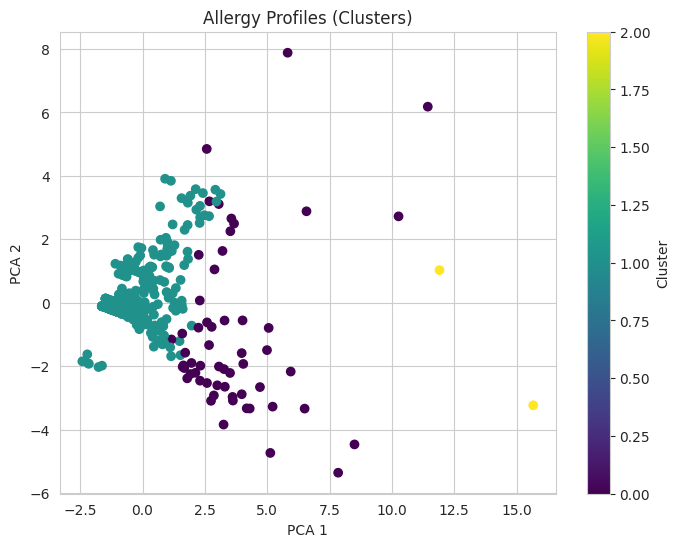

Confusion Matrix:
[[  8   2]
 [  1 107]]

 Accuracy Score:
0.9745762711864406

 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.98      0.99      0.99       108

    accuracy                           0.97       118
   macro avg       0.94      0.90      0.91       118
weighted avg       0.97      0.97      0.97       118



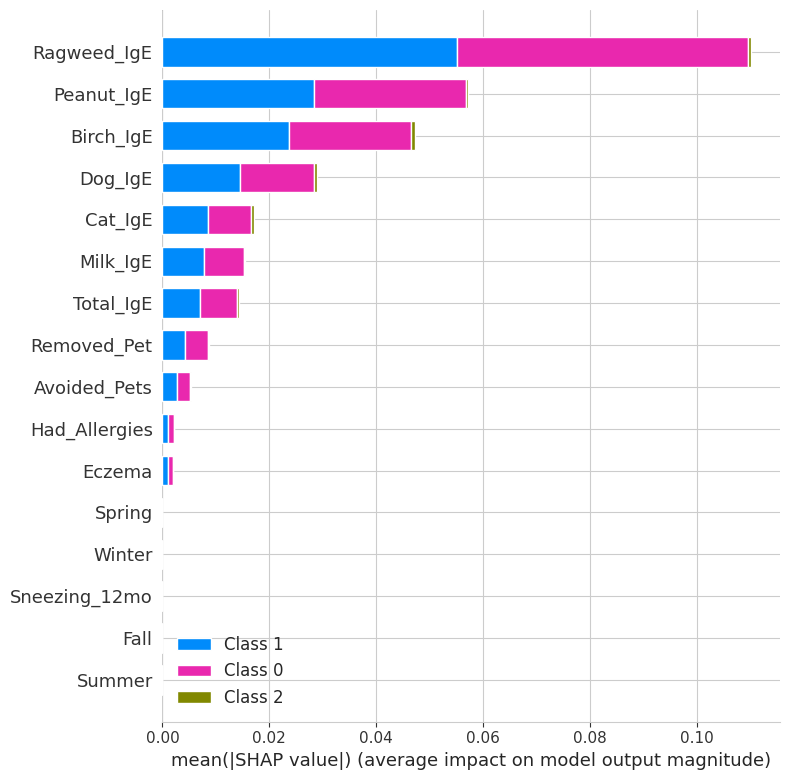

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#  Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap

# Load selected data from NHANES .xpt files (upload first!)
mcq = pd.read_sas("MCQ_D.xpt")[['SEQN']]  # Only for merging
ige = pd.read_sas("AL_IGE_D.xpt")[['SEQN', 'LBXIGE', 'LBXIE1', 'LBXIE5', 'LBXF13', 'LBXIF2', 'LBXIT3', 'LBXIW1']]
agq = pd.read_sas("AGQ_D.xpt")[['SEQN', 'AGQ040', 'AGQ070', 'AGQ090', 'AGQ100', 'AGQ110A', 'AGQ110B', 'AGQ110C', 'AGQ110D', 'AGQ180']]

#  Merge and clean
df = mcq.merge(ige, on='SEQN').merge(agq, on='SEQN')
df = df.dropna()

#  Rename columns for clarity
df = df.rename(columns={
    'LBXIGE': 'Total_IgE',
    'LBXIE1': 'Cat_IgE',
    'LBXIE5': 'Dog_IgE',
    'LBXF13': 'Peanut_IgE',
    'LBXIF2': 'Milk_IgE',
    'LBXIT3': 'Birch_IgE',
    'LBXIW1': 'Ragweed_IgE',
    'AGQ040': 'Had_Allergies',
    'AGQ070': 'Removed_Pet',
    'AGQ090': 'Avoided_Pets',
    'AGQ100': 'Sneezing_12mo',
    'AGQ110A': 'Spring',
    'AGQ110B': 'Summer',
    'AGQ110C': 'Fall',
    'AGQ110D': 'Winter',
    'AGQ180': 'Eczema'
})

# Preprocess
features = [
    'Total_IgE', 'Cat_IgE', 'Dog_IgE', 'Peanut_IgE', 'Milk_IgE',
    'Birch_IgE', 'Ragweed_IgE', 'Had_Allergies', 'Removed_Pet',
    'Avoided_Pets', 'Sneezing_12mo', 'Spring', 'Summer', 'Fall', 'Winter', 'Eczema'
]

X = df[features].copy()
X[features[:7]] = np.log1p(X[features[:7]])  # Log-transform IgE
X = X.apply(pd.to_numeric, errors='coerce').dropna()

# Unsupervised clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels back to df
df_clean = X.copy()
df_clean["Cluster"] = clusters

# Visualize clusters
# Use a custom pastel colormap
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title("Allergy Profiles (Clusters)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.show()


# Train classifier to explain clusters
X_train, X_test, y_train, y_test = train_test_split(X, clusters, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
#  Evaluate classifier
y_pred = clf.predict(X_test)


# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Accuracy score
print("\n Accuracy Score:")
print(accuracy_score(y_test, y_pred))

# Classification report
print("\n Classification Report:")
print(classification_report(y_test, y_pred))
# Explain using SHAP
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test)


# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns) # Changed "lightblue" to plt.cm.Blues
                                                                                                    # plt.cm.Blues provides a colormap for shades of blue

In [ ]:
X

,Total_IgE,Cat_IgE,Dog_IgE,Peanut_IgE,Milk_IgE,Birch_IgE,Ragweed_IgE,Had_Allergies,Removed_Pet,Avoided_Pets,Sneezing_12mo,Spring,Summer,Fall,Winter,Eczema
5,4.282206,2.821379,0.756122,0.223144,0.223144,0.223144,0.223144,1.0,2.0,1.0,1.0,1.0,2.0,3.0,4.0,1.0
37,4.432007,0.223144,0.223144,1.111858,0.223144,0.774727,1.050822,1.0,2.0,2.0,1.0,1.0,2.0,3.0,4.0,2.0
42,6.669498,0.223144,0.223144,0.223144,0.223144,0.223144,0.223144,2.0,2.0,2.0,1.0,1.0,2.0,3.0,4.0,2.0
73,2.687847,0.223144,1.098612,0.223144,0.223144,0.223144,0.223144,2.0,2.0,1.0,1.0,1.0,2.0,3.0,4.0,2.0
102,3.862833,0.223144,0.223144,0.223144,0.223144,0.223144,0.223144,1.0,2.0,2.0,1.0,1.0,2.0,3.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9360,3.387774,0.223144,0.223144,0.223144,0.223144,0.223144,0.223144,1.0,2.0,2.0,1.0,1.0,2.0,3.0,4.0,2.0
9365,3.081910,0.223144,0.223144,0.223144,0.223144,0.223144,0.223144,2.0,2.0,2.0,1.0,1.0,2.0,3.0,4.0,2.0
9384,4.237001,0.223144,0.223144,0.223144,0.223144,0.223144,0.223144,2.0,2.0,2.0,1.0,1.0,2.0,3.0,4.0,2.0
9400,4.820282,0.223144,0.223144,0.223144,0.223144,0.223144,0.223144,1.0,2.0,2.0,1.0,1.0,2.0,3.0,4.0,2.0
